In [89]:
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [154]:
# Excelファイルの読み込み
excel_file_path = 'all_data.xlsx'
csv_file_path = 'all_data.csv'
df = pd.read_excel(excel_file_path, sheet_name=0)

# 削除する列のリスト
columns_to_drop = ['Density [kg/m^3]', '緯度', '経度', 'DO eq', '備考', '水深', 'pH', 'Pressure',
                  'O2 weiss 1970', 'DIC[μmol/L@25℃]', 'Depth[m]', 'DO[ µmol/kg]',
                  'TA [μmol/kg]', 'Salinity', '日時', '場所', 'No.']

# 指定された列を削除
df.drop(columns=columns_to_drop, inplace=True)

df = df[df['label'] != -1]

# CSVファイルとして保存
df.to_csv(csv_file_path, index=False)
print(f"CSVファイルが保存されました: {csv_file_path}")
df

CSVファイルが保存されました: all_data.csv


,pCO2,AOU,excess DIC,T,nDIC+0.768DO,DIC-0.5TA+0.83DO,DO Saturation,label
18,609.054405,5.103117,65.754199,26.1010,2234.610383,1053.148478,0.975200,1
135,564.930029,12.868835,49.888406,18.0400,2285.756471,1132.068050,0.945459,1
136,566.704024,16.336327,50.400634,18.0700,2283.360541,1129.289180,0.930744,1
137,569.721742,8.624603,51.355938,18.2300,2288.770308,1135.138190,0.963304,1
138,568.501477,12.060292,50.985970,18.1700,2286.217390,1132.425550,0.948760,1
...,...,...,...,...,...,...,...,...
2060,542.771000,118.587515,49.811000,10.6016,2265.132400,1143.534000,0.521004,0
2061,557.977000,130.831224,53.484000,10.1420,2265.232200,1141.832000,0.483192,0
2062,519.493000,119.491733,43.128000,10.7688,2255.845200,1134.107000,0.516312,0
2063,538.981000,128.104189,48.153000,10.0288,2263.360400,1140.654000,0.493668,0


Basic LOF Model Evaluation:
accuracy: 0.973
precision: 0.107
recall: 0.107
f1: 0.107

Performing parameter tuning...

Best parameters:
n_neighbors: 40.0
contamination: 0.015
Accuracy: 0.995
precision: 0.821
recall: 0.821


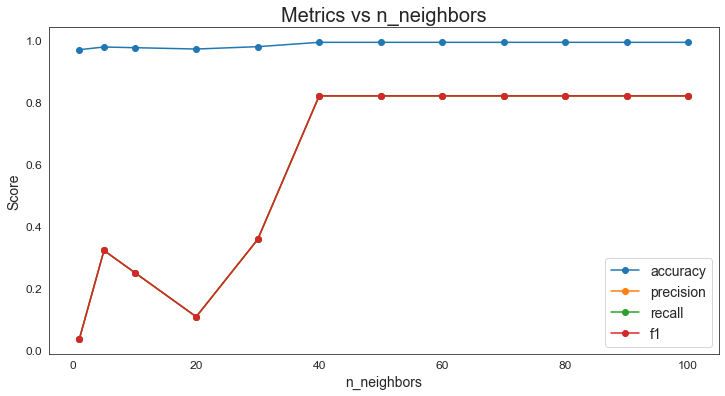

In [155]:
def evaluate_lof(X, y_true, n_neighbors=20, contamination=0.015):
    """
    LOFモデルを評価する関数

    Parameters:
    -----------
    X : array-like
        特徴量データ
    y_true : array-like
        実際のラベル (0: 正常, 1: 異常)
    n_neighbors : int
        近傍点の数
    contamination : float
        データセット中の異常値の予想される割合 (0.1に固定)

    Returns:
    --------
    dict : 評価指標の辞書
    """
    # LOFモデルの作成と予測
    lof = LocalOutlierFactor(n_neighbors=n_neighbors,
                            contamination=contamination,
                            novelty=False)

    # 予測（-1: 異常, 1: 正常 が返される）
    y_pred = lof.fit_predict(X)

    # -1, 1 を 1, 0 に変換
    y_pred = np.where(y_pred == -1, 1, 0)

    # 評価指標の計算
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred)
    }

    return metrics

def parameter_tuning(X, y_true):
    """
    異なるn_neighborsでLOFを評価する関数

    Parameters:
    -----------
    X : array-like
        特徴量データ
    y_true : array-like
        実際のラベル
    """
    # n_neighborsの範囲を設定
    n_neighbors_range = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    contamination = 0.015

    results = []

    for n in n_neighbors_range:
        metrics = evaluate_lof(X, y_true, n_neighbors=n, contamination=contamination)
        results.append({
            'n_neighbors': n,
            'contamination': contamination,
            **metrics
        })

    return pd.DataFrame(results)

def plot_results(results):
    plt.figure(figsize=(12, 6))
    metrics = ['accuracy', 'precision', 'recall', 'f1']

    for metric in metrics:
        plt.plot(results['n_neighbors'],
                results[metric],
                marker='o',
                label=metric)

    plt.xlabel('n_neighbors', fontsize=14)
    plt.ylabel('Score', fontsize=14)
    plt.title('Metrics vs n_neighbors', fontsize=20)
    plt.legend(fontsize=14)
    plt.grid(False)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    return plt.gcf()

def main(df):
    """
    メイン処理を実行する関数

    Parameters:
    -----------
    df : pandas.DataFrame
        特徴量とラベル('label')を含むデータフレーム
    """
    # 特徴量とラベルを分離
    X = df.drop('label', axis=1)
    y = df['label']

    # データの標準化
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 基本的なLOFモデルの評価
    print("Basic LOF Model Evaluation:")
    basic_metrics = evaluate_lof(X_scaled, y)
    for metric, value in basic_metrics.items():
        print(f"{metric}: {value:.3f}")

    # パラメータチューニング
    print("\nPerforming parameter tuning...")
    results = parameter_tuning(X_scaled, y)

    # 最良の結果を表示
    best_result = results.loc[results['f1'].idxmax()]
    print("\nBest parameters:")
    print(f"n_neighbors: {best_result['n_neighbors']}")
    print(f"contamination: {best_result['contamination']}")
    print(f"Accuracy: {best_result['accuracy']:.3f}")
    print(f"precision: {best_result['precision']:.3f}")
    print(f"recall: {best_result['recall']:.3f}")

    # 結果をプロット
    fig = plot_results(results)

    return results, fig

results, fig = main(df)
plt.show()

In [84]:
###使ってない
X = df.drop('label', axis=1)
y = df['label']

# データの標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# LOFのインスタンスを作成
lof = LocalOutlierFactor(n_neighbors=70, contamination=0.015, novelty=False)

# LOFを適用して異常スコアを計算
y_pred = lof.fit_predict(X)


# -1, 1 を 1, 0 に変換
y_pred = np.where(y_pred == -1, 1, 0)

# -1は異常（漏洩データ）、1は正常（非漏洩データ）を意味する
df['LOF_label'] = y_pred

# 異常（漏洩）データと正常（非漏洩）データに分割
leak_data = df[df['LOF_label'] == 1]
non_leak_data = df[df['LOF_label'] == 1]

# 結果をファイルに保存（オプション）
leak_data.to_csv('LOF_leak.csv', index=False)
non_leak_data.to_csv('LOF_non_leak.csv', index=False)

print("LOFのラベル付けが完了しました。")
print("漏洩データの数:", len(leak_data))
print("非漏洩データの数:", len(non_leak_data))

LOFのラベル付けが完了しました。
漏洩データの数: 28
非漏洩データの数: 1819


Performing parameter tuning with fixed contamination=0.16...

Best parameters (based on accuracy):
n_neighbors: 60
metric: minkowski

Metrics for best parameters:
accuracy: 0.928
precision: 0.785
recall: 0.773
f1: 0.779

Top 5 parameter combinations (sorted by accuracy):
    n_neighbors     metric  accuracy  precision    recall        f1
20           90  minkowski  0.927861   0.784615  0.772727  0.778626
18           80  minkowski  0.927861   0.784615  0.772727  0.778626
16           70  minkowski  0.927861   0.784615  0.772727  0.778626
14           60  minkowski  0.927861   0.784615  0.772727  0.778626
12           50  minkowski  0.922886   0.769231  0.757576  0.763359


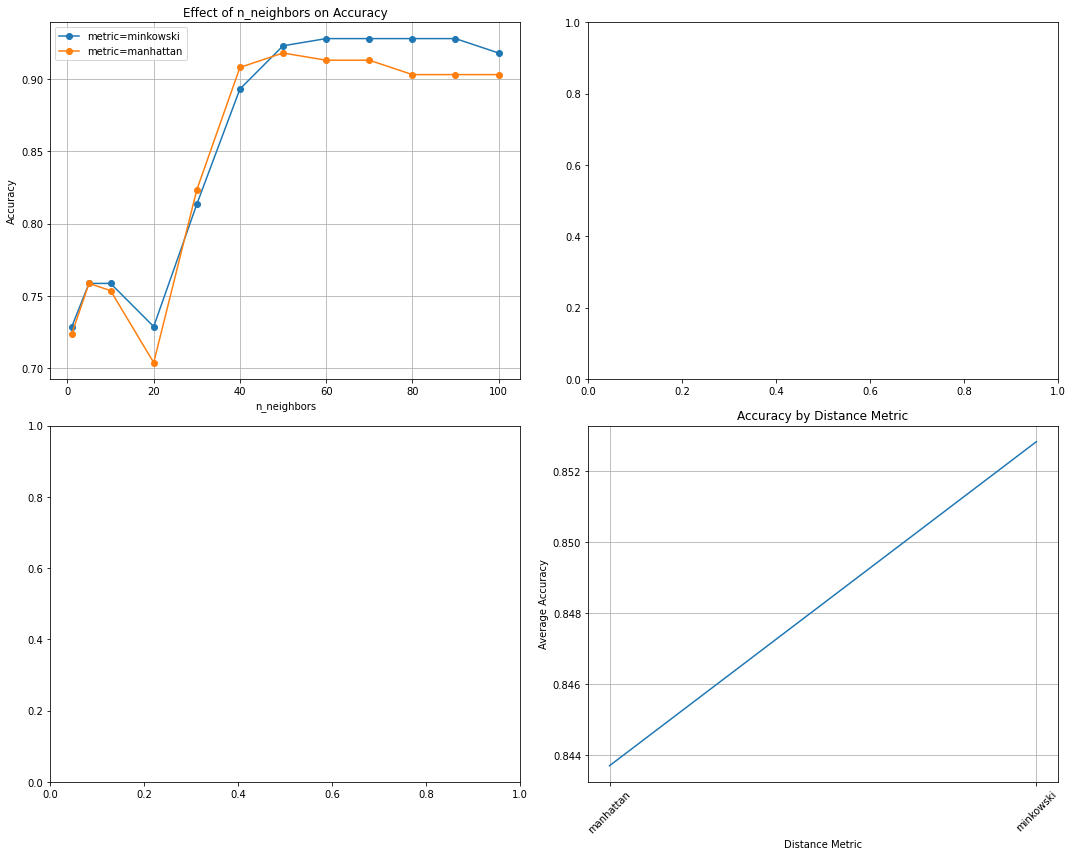

In [40]:
###使ってない
import numpy as np
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from itertools import product


#検討必要
def evaluate_lof(X, y_true, n_neighbors, metric):
    """
    LOFモデルを評価する関数（contamination固定版）
    """
    lof = LocalOutlierFactor(
        n_neighbors=n_neighbors,
        contamination=0.15,  # 固定値
        metric=metric,
        # p=p,
        # algorithm=algorithm,
        # leaf_size=leaf_size,
        novelty=False
    )

    y_pred = lof.fit_predict(X)
    y_pred = np.where(y_pred == -1, 1, 0)

    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred)
    }

    return metrics

def parameter_tuning(X, y_true):
    """
    パラメータチューニングを行う関数
    """
    param_grid = {
        'n_neighbors': [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
        'metric': ['minkowski', 'manhattan'],
        # 'p': [1, 2],
        # 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        # 'leaf_size': [20, 30, 40]
    }

    results = []

    for params in product(*[param_grid[key] for key in param_grid.keys()]):
        param_dict = dict(zip(param_grid.keys(), params))
        metrics = evaluate_lof(X, y_true, **param_dict)
        results.append({**param_dict, **metrics})

    # for params in product(*[param_grid[key] for key in param_grid.keys()]):
    #     param_dict = dict(zip(param_grid.keys(), params))

    #     # 距離メトリックの整合性チェック
    #     if param_dict['metric'] == 'cosine':
    #         continue
    #     if param_dict['metric'] == 'manhattan' and param_dict['p'] != 1:
    #         continue
    #     if param_dict['metric'] == 'euclidean' and param_dict['p'] != 2:
    #         continue

    #     metrics = evaluate_lof(X, y_true, **param_dict)
    #     results.append({**param_dict, **metrics})

    return pd.DataFrame(results)

def plot_parameter_effects(results):
    """
    各パラメータの影響をプロットする関数（accuracyベース）
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # n_neighborsの影響
    ax = axes[0, 0]
    for metric in results['metric'].unique():
        mask = results['metric'] == metric
        data = results[mask].groupby('n_neighbors')['accuracy'].mean()
        ax.plot(data.index, data.values, marker='o', label=f'metric={metric}')
    # for metric in results['metric'].unique():
    #     mask = results['metric'] == metric
    #     data = results[mask].groupby('n_neighbors')['accuracy'].mean()
    #     ax.plot(data.index, data.values, marker='o', label=f'metric={metric}')
    ax.set_xlabel('n_neighbors')
    ax.set_ylabel('Accuracy')
    ax.set_title('Effect of n_neighbors on Accuracy')
    ax.legend()
    ax.grid(True)

    """
    # leaf_sizeの影響
    ax = axes[0, 1]
    for algo in results['algorithm'].unique():
        if algo != 'brute':  # bruteはleaf_sizeを使用しない
            mask = results['algorithm'] == algo
            data = results[mask].groupby('leaf_size')['accuracy'].mean()
            ax.plot(data.index, data.values, marker='o', label=f'algorithm={algo}')
    ax.set_xlabel('leaf_size')
    ax.set_ylabel('Accuracy')
    ax.set_title('Effect of leaf_size on Accuracy')
    ax.legend()
    ax.grid(True)

    # アルゴリズムの比較
    ax = axes[1, 0]
    data = results.groupby('algorithm')['accuracy'].mean()
    ax.plot(data.index, data.values)
    ax.set_xlabel('Algorithm')
    ax.set_ylabel('Average Accuracy')
    ax.set_title('Accuracy by Algorithm')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True)
    """

    # 距離メトリックの比較
    ax = axes[1, 1]
    data = results.groupby('metric')['accuracy'].mean()
    ax.plot(data.index, data.values)
    ax.set_xlabel('Distance Metric')
    ax.set_ylabel('Average Accuracy')
    ax.set_title('Accuracy by Distance Metric')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True)

    plt.tight_layout()
    return fig

def main(df):
    """
    メイン処理を実行する関数
    """
    # 特徴量とラベルを分離
    X = df.drop('label', axis=1)
    y = df['label']

    # データの標準化
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # パラメータチューニング
    print("Performing parameter tuning with fixed contamination=0.16...")
    results = parameter_tuning(X_scaled, y)

    # 最良の結果を表示（accuracyベース）
    best_result = results.loc[results['accuracy'].idxmax()]
    print("\nBest parameters (based on accuracy):")
    for param, value in best_result.items():
        if param not in ['accuracy', 'precision', 'recall', 'f1']:
            print(f"{param}: {value}")
    print(f"\nMetrics for best parameters:")
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        print(f"{metric}: {best_result[metric]:.3f}")

    # パラメータの影響をプロット
    fig = plot_parameter_effects(results)

    # 詳細な結果の表示（accuracyでソート）
    print("\nTop 5 parameter combinations (sorted by accuracy):")
    print(results.sort_values('accuracy', ascending=False).head().to_string())

    return results, fig


results, fig = main(df)
plt.show()

In [152]:
###生データ
excel_file_path = 'all_data.xlsx'
csv_file_path = 'all_data.csv'
df = pd.read_excel(excel_file_path, sheet_name=0)

df = df[df['label'] != -1]

# 削除する列のリスト
columns_to_drop = ['水深','Density [kg/m^3]', '緯度', '経度', 'DO eq', '備考', 'pH', 'Pressure',
                  'O2 weiss 1970', '日時', '場所', 'No.', 'Depth[m]', 'Salinity', 'AOU', 'excess DIC', 'nDIC+0.768DO','DIC-0.5TA+0.83DO', 'DO Saturation']

# 指定された列を削除
df.drop(columns=columns_to_drop, inplace=True)

# CSVファイルとして保存
df.to_csv(csv_file_path, index=False)
print(f"CSVファイルが保存されました: {csv_file_path}")
df

CSVファイルが保存されました: all_data.csv


,pCO2,T,TA [μmol/kg],DO[ µmol/kg],DIC[μmol/L@25℃],label
18,609.054405,26.1010,2153.3,201.181294,1962.818004,1
135,564.930029,18.0400,2230.0,223.335000,2061.700000,1
136,566.704024,18.0700,2229.6,219.746000,2061.700000,1
137,569.721742,18.2300,2229.6,226.793000,2061.700000,1
138,568.501477,18.1700,2229.7,223.585000,2061.700000,1
...,...,...,...,...,...,...
2060,542.771000,10.6016,2325.8,149.800000,2182.100000,0
2061,557.977000,10.1420,2322.4,140.400000,2186.500000,0
2062,519.493000,10.7688,2326.1,147.900000,2174.400000,0
2063,538.981000,10.0288,2323.8,143.800000,2183.200000,0


In [150]:
# Excelファイルの読み込み
excel_file_path = 'all_data.xlsx'
csv_file_path = 'all_data.csv'
df = pd.read_excel(excel_file_path, sheet_name=0)

# 削除する列のリスト
columns_to_drop = ['Density [kg/m^3]', '緯度', '経度', 'DO eq', '備考', '水深', 'pH', 'Pressure',
                  'O2 weiss 1970', 'DIC[μmol/L@25℃]', 'Depth[m]', 'DO[ µmol/kg]',
                  'TA [μmol/kg]', 'Salinity', '日時', '場所', 'No.', 'DIC-0.5TA+0.83DO']

# 指定された列を削除
df.drop(columns=columns_to_drop, inplace=True)

df = df[df['label'] != -1]

# CSVファイルとして保存
df.to_csv(csv_file_path, index=False)
print(f"CSVファイルが保存されました: {csv_file_path}")
df

CSVファイルが保存されました: all_data.csv


,pCO2,AOU,excess DIC,T,nDIC+0.768DO,DO Saturation,label
18,609.054405,5.103117,65.754199,26.1010,2234.610383,0.975200,1
135,564.930029,12.868835,49.888406,18.0400,2285.756471,0.945459,1
136,566.704024,16.336327,50.400634,18.0700,2283.360541,0.930744,1
137,569.721742,8.624603,51.355938,18.2300,2288.770308,0.963304,1
138,568.501477,12.060292,50.985970,18.1700,2286.217390,0.948760,1
...,...,...,...,...,...,...,...
2060,542.771000,118.587515,49.811000,10.6016,2265.132400,0.521004,0
2061,557.977000,130.831224,53.484000,10.1420,2265.232200,0.483192,0
2062,519.493000,119.491733,43.128000,10.7688,2255.845200,0.516312,0
2063,538.981000,128.104189,48.153000,10.0288,2263.360400,0.493668,0


Basic LOF Model Evaluation:
accuracy: 0.979
precision: 0.211
recall: 0.143
f1: 0.170

Performing parameter tuning...

Best parameters:
n_neighbors: 5.0
contamination: 0.01
Accuracy: 0.982
precision: 0.368
recall: 0.250


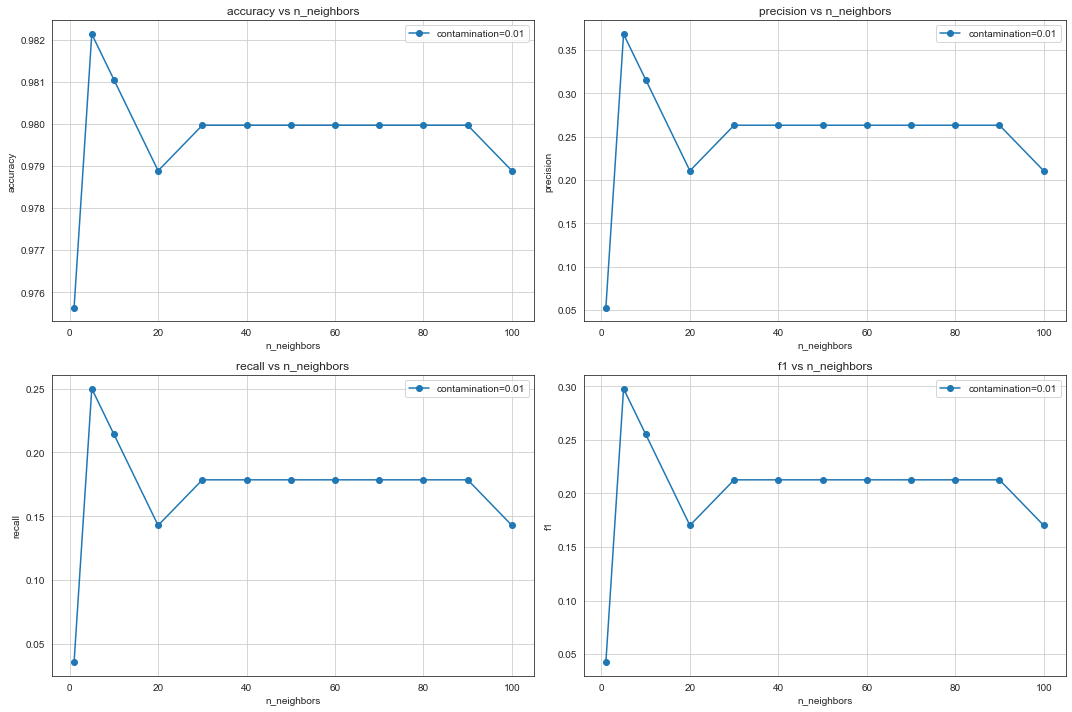

In [137]:
###使ってない
def evaluate_lof(X, y_true, n_neighbors=20, contamination=0.01):
    """
    LOFモデルを評価する関数

    Parameters:
    -----------
    X : array-like
        特徴量データ
    y_true : array-like
        実際のラベル (0: 正常, 1: 異常)
    n_neighbors : int
        近傍点の数
    contamination : float
        データセット中の異常値の予想される割合 (0.1に固定)

    Returns:
    --------
    dict : 評価指標の辞書
    """
    # LOFモデルの作成と予測
    lof = LocalOutlierFactor(n_neighbors=n_neighbors,
                            contamination=contamination,
                            novelty=False)

    # 予測（-1: 異常, 1: 正常 が返される）
    y_pred = lof.fit_predict(X)

    # -1, 1 を 1, 0 に変換
    y_pred = np.where(y_pred == -1, 1, 0)

    # 評価指標の計算
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred)
    }

    return metrics

def parameter_tuning(X, y_true):
    """
    異なるn_neighborsでLOFを評価する関数

    Parameters:
    -----------
    X : array-like
        特徴量データ
    y_true : array-like
        実際のラベル
    """
    # n_neighborsの範囲を設定
    n_neighbors_range = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    contamination = 0.01

    results = []

    for n in n_neighbors_range:
        metrics = evaluate_lof(X, y_true, n_neighbors=n, contamination=contamination)
        results.append({
            'n_neighbors': n,
            'contamination': contamination,
            **metrics
        })

    return pd.DataFrame(results)

def plot_results(results):
    """
    パラメータチューニングの結果をプロットする関数

    Parameters:
    -----------
    results : pandas.DataFrame
        パラメータチューニングの結果
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    metrics = ['accuracy', 'precision', 'recall', 'f1']

    for ax, metric in zip(axes.flat, metrics):
        ax.plot(results['n_neighbors'],
               results[metric],
               marker='o',
               label=f'contamination=0.01')

        ax.set_xlabel('n_neighbors')
        ax.set_ylabel(metric)
        ax.set_title(f'{metric} vs n_neighbors')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    return fig

def main(df):
    """
    メイン処理を実行する関数

    Parameters:
    -----------
    df : pandas.DataFrame
        特徴量とラベル('label')を含むデータフレーム
    """
    # 特徴量とラベルを分離
    X = df.drop('label', axis=1)
    y = df['label']

    # データの標準化
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 基本的なLOFモデルの評価
    print("Basic LOF Model Evaluation:")
    basic_metrics = evaluate_lof(X_scaled, y)
    for metric, value in basic_metrics.items():
        print(f"{metric}: {value:.3f}")

    # パラメータチューニング
    print("\nPerforming parameter tuning...")
    results = parameter_tuning(X_scaled, y)

    # 最良の結果を表示
    best_result = results.loc[results['f1'].idxmax()]
    print("\nBest parameters:")
    print(f"n_neighbors: {best_result['n_neighbors']}")
    print(f"contamination: {best_result['contamination']}")
    print(f"Accuracy: {best_result['accuracy']:.3f}")
    print(f"precision: {best_result['precision']:.3f}")
    print(f"recall: {best_result['recall']:.3f}")

    # 結果をプロット
    fig = plot_results(results)

    return results, fig

results, fig = main(df)
plt.show()